# Setup

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import statsmodels.api as sm

from Bio.SeqUtils import GC
import vcf

from IPython.display import display

DIR = r'c://downloads'

plt.style.use('ggplot')

# Q1A

In [2]:
RELEVANT_CONSEQUENCES = [
    'synonymous_variant',
    'missense_variant',
    'stop_gained',
    'frameshift_variant',
]

vcf_reader = vcf.Reader(filename = os.path.join(DIR, 'ExAC.r1.sites.chr22.vep.vcf.gz'), compressed = True)

CSQ_format, = re.findall('Format: (.*)', vcf_reader.infos['CSQ'].desc)
CSQ_keys = CSQ_format.split('|')

variant_consequences = []

for i, variant in enumerate(vcf_reader):

    if i % 100 == 0:
        print('Variant #%d' % i, end = '\r')
    
    # The CSQ INFO field stores the conseuqnces of the variant, as annotated by the VEP software
    # (https://www.ensembl.org/info/docs/tools/vep/index.html).
    # We parse it into a dataframe (each row a different annotation of the same variant).
    CSQs = pd.DataFrame([CSQ.split('|') for CSQ in variant.INFO['CSQ']], columns = CSQ_keys)
    # The "Consequence" field of CSQ stores the actual consequences (of a pre-defined set of possible labels). 
    # Potentially, each annotation can have multiple consequence labels, separated by &. Therefore, we will parse it
    # into a set.
    CSQs['Consequence'] = CSQs['Consequence'].apply(lambda raw_consequence: set(raw_consequence.split('&')))
    
    # When a variant has multiple alternative alleles, each of them should be treated separately, so we group by the CSQ
    # annotations by "ALLELE_NUM".
    for allele_num, allele_CSQs in CSQs.groupby('ALLELE_NUM'):
    
        # We determine the allele-frequency (AF) of the variant's allele, and the set of relevant consequences it is
        # annotated with.
        AF = variant.INFO['AF'][int(allele_num) - 1]
        allele_relevant_consequences = set.union(*allele_CSQs['Consequence']) & set(RELEVANT_CONSEQUENCES)
        
        for consequence in allele_relevant_consequences:
            variant_consequences.append((consequence, variant.REF, AF))
            
variant_consequences = pd.DataFrame(variant_consequences, columns = ['consequence', 'ref_nt', 'AF'])
display(variant_consequences)

,consequence,ref_nt,AF
0,missense_variant,C,0.000123
1,missense_variant,G,0.000032
2,synonymous_variant,A,0.000970
3,synonymous_variant,A,0.000030
4,missense_variant,T,0.000029
5,missense_variant,T,0.000944
6,missense_variant,C,0.000030
7,frameshift_variant,GTTCA,0.000029
8,missense_variant,T,0.000029
9,frameshift_variant,TCA,0.000029


ANOVA p-value (in log scale): 3e-185


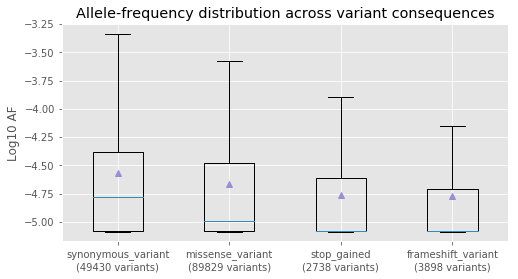

In [3]:
variants_per_consequence = variant_consequences.groupby('consequence')
consequences_log10_AFs = [np.log10(variants_per_consequence['AF'].get_group(consequence)) for consequence in \
        RELEVANT_CONSEQUENCES]

_, pval = f_oneway(*consequences_log10_AFs)
print('ANOVA p-value (in log scale): %.1g' % pval)

fig, ax = plt.subplots(figsize = (8, 4))
ax.boxplot(consequences_log10_AFs, showfliers = False, showmeans = True)
ax.set_xticklabels(['%s\n(%d variants)' % (consequence, len(log10_AFs)) for consequence, log10_AFs in \
        zip(RELEVANT_CONSEQUENCES, consequences_log10_AFs)])
ax.set_ylabel('Log10 AF')
ax.yaxis.grid(True)
_ = ax.set_title('Allele-frequency distribution across variant consequences')

We see that synonymous variants have, on average, the highest allele frequencies, and loss-of-function variants (nonsense and frameshift) the lowest. Missense variants have intermediate allele frequencies. 

# Q1B

GC content might be a confounder because it is a third variable that might causally affect the two variables in question (variant consequences and allele frequency). It might affect the consequences of variants due to the structure of the codon table (as some nucleotide substitutions might be synonymous with higher probability, while others might lead to missense or nonsense variants with higher probability). On the other hand, GC content might also affect allele frequency. For example, variants with low allele frequency are, very commonly, variants which are relatively young in evolutionary terms (and, therefore, have not fixed in large fraction of the population). As higher GC content leads to higher mutation rate (see for example [Deterministic Mutation Rate Variation in the Human Genome, 2002](https://genome.cshlp.org/content/12/9/1350.full)), it is expected that younger mutations would be enriched in area with higher GC content. Of course this is just one posible theory. There are many causal chains that could lead GC content, or other variables, to become confounders.

To control for the potential confounding effect of GC content, we will carry out a logistic regression analysis that models the consequence of a variant as a function of its allele frequency (the variable in question) and the GC content of the reference allele (a covariate to control for). For simplicity, we will focus on synonymous variants, so the output variable y would be a binary variable stating whether the variant is synonymous or missense/nonsense/frameshift.

In [4]:
y = (variant_consequences['consequence'] == 'synonymous_variant').astype(int)
X = sm.add_constant(pd.concat([np.log10(variant_consequences['AF']).rename('log10_AF'), \
        variant_consequences['ref_nt'].apply(GC).rename('ref_GC')], axis = 1))
model = sm.OLS(y, X)
model_results = model.fit()
pval = model_results.pvalues['log10_AF']
print(('Analyzing the effect of AF (in logs scale) on whether a variant is synonymous (%d%% of the analyzed variants) ' + \
        'across %d variants, while accounting for GC content, has produced a p-value of %.2g.') % (100 * y.mean(), \
        len(variant_consequences), pval))

Analyzing the effect of AF (in logs scale) on whether a variant is synonymous (33% of the analyzed variants) across 145895 variants, while accounting for GC content, has produced a p-value of 5.7e-140.


Apparently, GC content alone doesn't explain the association between allele frequency to variant consequence.

# Q1D

Despite the possibility of technical issues and other confounders (e.g. the discussed GC contnet, or more general backgrounds of nucleotide distributions, or technical sequencing/calling issues), the most likely theory is that the consequences of variants at the molecular level (i.e.e synonymous, missense, nonsense, etc.) actually affect their prevalence through the process of natural selection, as deleterious variants are more likely to be pathogenic and reduce one's fitness.